# devlog 2024-02-06

Development of age-structured IPMs.

Our first task is to "hand-build" an age-structured IPM where the compartmental model for each class is the same. (I will use age as the class distinction here, because it is relatively straight-forward to acquire breakdowns of population by age. But it's worth remembering that in many ways "age" is a placeholder for any type of classification -- by race/ethnicity, or risk category, socio-economic class, etc.)

In [1]:
from sympy import Max

from epymorph import *
from epymorph.compartment_model import *

# Basing these age classes on:
# "Age-stratified transmission model of COVID-19 in Ontario with human mobility during pandemic's first wave"; 2021; Fields, et al
# https://doi.org/10.1016%2Fj.heliyon.2021.e07905

# age classes:
# 1: [0,20) years
# 2: [20,60) years
# 3: [60,80) years


def construct_ipm_1() -> CompartmentModel:
    # IPM 1:
    # This IPM combines all infection pressure for an age class into one event.
    symbols = create_symbols(
        compartments=[
            compartment('S_1'),
            compartment('S_2'),
            compartment('S_3'),
            compartment('I_1'),
            compartment('I_2'),
            compartment('I_3'),
            compartment('R_1'),
            compartment('R_2'),
            compartment('R_3'),
        ],
        attributes=[
            # infectivity matrix
            # (Would be nicer to pass a CxC, TxCxC, or TxNxCxC array... but how would we unpack it?)
            param('beta_11', shape=Shapes.TxN),
            param('beta_12', shape=Shapes.TxN),
            param('beta_13', shape=Shapes.TxN),
            param('beta_21', shape=Shapes.TxN),
            param('beta_22', shape=Shapes.TxN),
            param('beta_23', shape=Shapes.TxN),
            param('beta_31', shape=Shapes.TxN),
            param('beta_32', shape=Shapes.TxN),
            param('beta_33', shape=Shapes.TxN),
            # progression from infected to recovered
            param('gamma', shape=Shapes.TxN),
            # progression from recovered to susceptible
            param('xi', shape=Shapes.TxN),
        ])

    [S_1, S_2, S_3, I_1, I_2, I_3, R_1, R_2, R_3] = symbols.compartment_symbols
    [beta_11, beta_12, beta_13, beta_21, beta_22, beta_23, beta_31,
        beta_32, beta_33, gamma, xi] = symbols.attribute_symbols

    N = Max(1, S_1 + I_1 + R_1 + S_2 + I_2 + R_2 + S_3 + I_3 + R_3)

    return create_model(
        symbols=symbols,
        transitions=[
            edge(S_1, I_1, rate=S_1 * (beta_11 * I_1 + beta_12 * I_2 + beta_13 * I_3) / N),
            edge(S_2, I_2, rate=S_2 * (beta_21 * I_1 + beta_22 * I_2 + beta_23 * I_3) / N),
            edge(S_3, I_3, rate=S_3 * (beta_31 * I_1 + beta_32 * I_2 + beta_33 * I_3) / N),
            edge(I_1, R_1, rate=gamma * I_1),
            edge(I_2, R_2, rate=gamma * I_2),
            edge(I_3, R_3, rate=gamma * I_3),
            edge(R_1, S_1, rate=xi * R_1),
            edge(R_2, S_2, rate=xi * R_2),
            edge(R_3, S_3, rate=xi * R_3),
        ])


def construct_ipm_2() -> CompartmentModel:
    # IPM 2:
    # This IPM mocks a more modular configuration, as though three separate IPMs were combined with meta-edges.
    # In this case, the infection pressures attributed to each pair of age classes are represented as separate events.
    # However this implementation uses a formulation of N which combines all populations.
    # This is to avoid problems with scaling beta values.
    symbols = create_symbols(
        compartments=[
            compartment('S_1'),
            compartment('S_2'),
            compartment('S_3'),
            compartment('I_1'),
            compartment('I_2'),
            compartment('I_3'),
            compartment('R_1'),
            compartment('R_2'),
            compartment('R_3'),
        ],
        attributes=[
            # infectivity matrix
            param('beta_11', shape=Shapes.TxN),
            param('beta_12', shape=Shapes.TxN),
            param('beta_13', shape=Shapes.TxN),
            param('beta_21', shape=Shapes.TxN),
            param('beta_22', shape=Shapes.TxN),
            param('beta_23', shape=Shapes.TxN),
            param('beta_31', shape=Shapes.TxN),
            param('beta_32', shape=Shapes.TxN),
            param('beta_33', shape=Shapes.TxN),
            # progression from infected to recovered
            param('gamma', shape=Shapes.TxN),
            # progression from recovered to susceptible
            param('xi', shape=Shapes.TxN),
        ])

    [S_1, S_2, S_3, I_1, I_2, I_3, R_1, R_2, R_3] = symbols.compartment_symbols
    [beta_11, beta_12, beta_13, beta_21, beta_22, beta_23, beta_31,
        beta_32, beta_33, gamma, xi] = symbols.attribute_symbols

    N = Max(1, S_1 + I_1 + R_1 + S_2 + I_2 + R_2 + S_3 + I_3 + R_3)

    return create_model(
        symbols=symbols,
        transitions=[
            # SIR for age class 1
            edge(S_1, I_1, rate=S_1 * beta_11 * I_1 / N),
            edge(I_1, R_1, rate=gamma * I_1),
            edge(R_1, S_1, rate=xi * R_1),

            # SIR for age class 2
            edge(S_2, I_2, rate=S_2 * beta_22 * I_2 / N),
            edge(I_2, R_2, rate=gamma * I_2),
            edge(R_2, S_2, rate=xi * R_2),

            # SIR for age class 3
            edge(S_3, I_3, rate=S_3 * beta_33 * I_3 / N),
            edge(I_3, R_3, rate=gamma * I_3),
            edge(R_3, S_3, rate=xi * R_3),

            # The meta-edges describing the interactions between each age class
            edge(S_1, I_1, rate=S_1 * beta_12 * I_2 / N),  # 2 infects 1
            edge(S_1, I_1, rate=S_1 * beta_13 * I_3 / N),  # 3 infects 1
            edge(S_2, I_2, rate=S_2 * beta_21 * I_1 / N),  # 1 infects 2
            edge(S_2, I_2, rate=S_2 * beta_23 * I_3 / N),  # 3 infects 2
            edge(S_3, I_3, rate=S_3 * beta_31 * I_1 / N),  # 1 infects 3
            edge(S_3, I_3, rate=S_3 * beta_32 * I_2 / N),  # 2 infects 3
        ])


def construct_ipm_3() -> CompartmentModel:
    # IPM 3:
    # This IPM uses a similar modular approach as in IPM 2, but attempts to scale beta
    # so that its values are comparable to the others while formulating N specific to the
    # populations involved in a particular event.
    symbols = create_symbols(
        compartments=[
            compartment('S_1'),
            compartment('S_2'),
            compartment('S_3'),
            compartment('I_1'),
            compartment('I_2'),
            compartment('I_3'),
            compartment('R_1'),
            compartment('R_2'),
            compartment('R_3'),
        ],
        attributes=[
            # infectivity matrix
            param('beta_11', shape=Shapes.TxN),
            param('beta_12', shape=Shapes.TxN),
            param('beta_13', shape=Shapes.TxN),
            param('beta_21', shape=Shapes.TxN),
            param('beta_22', shape=Shapes.TxN),
            param('beta_23', shape=Shapes.TxN),
            param('beta_31', shape=Shapes.TxN),
            param('beta_32', shape=Shapes.TxN),
            param('beta_33', shape=Shapes.TxN),
            # progression from infected to recovered
            param('gamma', shape=Shapes.TxN),
            # progression from recovered to susceptible
            param('xi', shape=Shapes.TxN),
        ])

    [S_1, S_2, S_3, I_1, I_2, I_3, R_1, R_2, R_3] = symbols.compartment_symbols
    [beta_11_us, beta_12_us, beta_13_us, beta_21_us, beta_22_us, beta_23_us, beta_31_us,
        beta_32_us, beta_33_us, gamma, xi] = symbols.attribute_symbols

    N1 = S_1 + I_1 + R_1
    N2 = S_2 + I_2 + R_2
    N3 = S_3 + I_3 + R_3
    N = N1 + N2 + N3

    # in `beta_ab_us` the "us" is for "unscaled"
    # now we need to scale to the available population so that we can use
    # the same beta values for all three IPMs and get similar results
    beta_11 = beta_11_us * (N1) / N
    beta_12 = beta_12_us * (N1 + N2) / N
    beta_13 = beta_13_us * (N1 + N3) / N
    beta_21 = beta_21_us * (N2 + N1) / N
    beta_22 = beta_22_us * (N2) / N
    beta_23 = beta_23_us * (N2 + N3) / N
    beta_31 = beta_31_us * (N3 + N1) / N
    beta_32 = beta_32_us * (N3 + N2) / N
    beta_33 = beta_33_us * (N3) / N

    return create_model(
        symbols=symbols,
        transitions=[
            # SIR for age class 1
            edge(S_1, I_1, rate=S_1 * beta_11 * I_1 / N1),
            edge(I_1, R_1, rate=gamma * I_1),
            edge(R_1, S_1, rate=xi * R_1),

            # SIR for age class 2
            edge(S_2, I_2, rate=S_2 * beta_22 * I_2 / N2),
            edge(I_2, R_2, rate=gamma * I_2),
            edge(R_2, S_2, rate=xi * R_2),

            # SIR for age class 3
            edge(S_3, I_3, rate=S_3 * beta_33 * I_3 / N3),
            edge(I_3, R_3, rate=gamma * I_3),
            edge(R_3, S_3, rate=xi * R_3),

            # The meta-edges describing the interactions between each age class
            edge(S_1, I_1, rate=S_1 * beta_12 * I_2 / (N1 + N2)),  # 2 infects 1
            edge(S_1, I_1, rate=S_1 * beta_13 * I_3 / (N1 + N3)),  # 3 infects 1
            edge(S_2, I_2, rate=S_2 * beta_21 * I_1 / (N2 + N1)),  # 1 infects 2
            edge(S_2, I_2, rate=S_2 * beta_23 * I_3 / (N2 + N3)),  # 3 infects 2
            edge(S_3, I_3, rate=S_3 * beta_31 * I_1 / (N3 + N1)),  # 1 infects 3
            edge(S_3, I_3, rate=S_3 * beta_32 * I_2 / (N3 + N2)),  # 2 infects 3
        ])


infection_events_ipm1 = [[3], [4], [5]]
infection_events_ipm2 = [[0, 9, 10], [3, 11, 12], [6, 13, 14]]
infection_events_ipm3 = [[0, 9, 10], [3, 11, 12], [6, 13, 14]]

In [2]:
import numpy as np

from epymorph.geo.spec import LABEL, NO_DURATION, AttribDef, StaticGeoSpec
from epymorph.geo.static import StaticGeo
from epymorph.initializer import InitContext

geo = StaticGeo(
    spec=StaticGeoSpec(
        attributes=[
            LABEL,
            AttribDef('population_by_age', SimDType, Shapes.NxA(3)),
        ],
        time_period=NO_DURATION,
    ),
    values={
        # Data from 2022 ACS 1-year (S0101)
        # https://data.census.gov/table/ACSST1Y2022.S0101?q=population%20by%20age&g=050XX00US04013
        'label': np.array(['Maricopa County'], dtype=np.str_),
        'population_by_age': np.array([[1_136_107, 2_412_395, 839_799]], dtype=SimDType),
    },
)


def initializer(ctx: InitContext):
    _, N, C, _ = ctx.dim.TNCE
    values = np.zeros((N, C), dtype=SimDType)
    # Start with population in Susceptible
    values[:, 0:3] = ctx.geo['population_by_age']
    # Initialize 100 Infected in class 2 (20-to-60-year-olds)
    values[0, 1] -= 100
    values[0, 4] += 100
    return values

In [3]:
from functools import reduce

import matplotlib.pyplot as plt


def run_experiment(ipm: CompartmentModel, infection_events: list[list[int]]) -> None:
    # Construct sim and run
    sim = StandardSimulation(
        geo=geo,
        ipm=ipm,
        mm=mm_library['no'](),
        params={
            'beta_11': 0.1,
            'beta_12': 0.1,
            'beta_13': 0.1,
            'beta_21': 0.3,
            'beta_22': 0.3,
            'beta_23': 0.3,
            'beta_31': 0.6,
            'beta_32': 0.6,
            'beta_33': 0.6,
            'gamma': 1 / 10,
            'xi': 1 / 90,
        },
        time_frame=TimeFrame.of("2022-01-01", 365),
        initializer=initializer,
        # rng=default_rng(1),
    )

    with sim_messaging(sim):
        out = sim.run()
        # calc total new infections (depending on the IPM this may represent this as separate events)
        infections = [
            reduce(lambda a, b: a + b,
                   (out.incidence[:, 0, j] for j in infection_events[i]))
            for i in [0, 1, 2]
        ]

    # Plot results
    age_label = ['age [0,20)', 'age [20,60)', 'age [60,80)']
    age_total_thousands = geo['population_by_age'][0] / 1000
    t_window = slice(0, None)

    # Day of Peak Infection by age class
    dpi = [
        int(np.argmax(infections[i])) // out.dim.tau_steps
        for i in [0, 1, 2]
    ]
    dpi_x_pos = 120

    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))
    x_axis = np.arange(out.dim.days)[t_window]

    ax1.set_title('New infections by age class')
    ax1.set_ylabel('occurrences')
    for i in [0, 1, 2]:
        color = ax1._get_lines.get_next_color()
        y_axis = infections[i][t_window]
        ax1.plot(x_axis, y_axis, color=color, label=age_label[i])
        # Mark day of peak infection
        d = dpi[i]
        ax1.text(dpi_x_pos, y_axis[d] - 1000, f"day {d}", color=color)
        ax1.hlines(y=y_axis[d], xmin=d, xmax=dpi_x_pos - 1,
                   color=color, linewidth=0.5, linestyle='dashed')
    ax1.legend()

    ax2.set_title('New infections by age class (per thousand)')
    ax2.set_xlabel('days')
    ax2.set_ylabel('occurrences per thousand')
    for i in [0, 1, 2]:
        y_axis = infections[i][t_window] / age_total_thousands[i]
        ax2.plot(x_axis, y_axis, label=age_label[i])
    ax2.legend()

    fig.tight_layout()
    plt.show()

Running simulation (StandardSimulation):
• 2022-01-01 to 2023-01-01 (365 days)
• 1 geo nodes
|####################| 100% 
Runtime: 0.050s


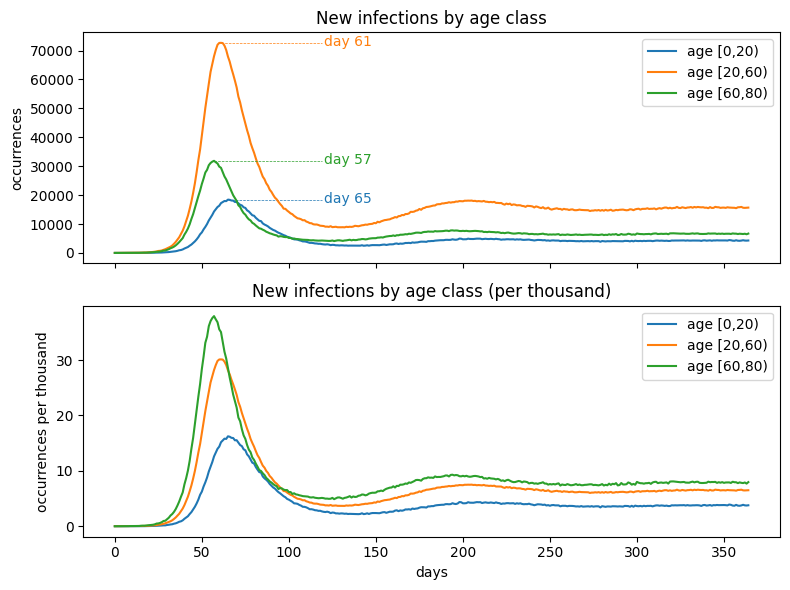

Running simulation (StandardSimulation):
• 2022-01-01 to 2023-01-01 (365 days)
• 1 geo nodes
|####################| 100% 
Runtime: 0.080s


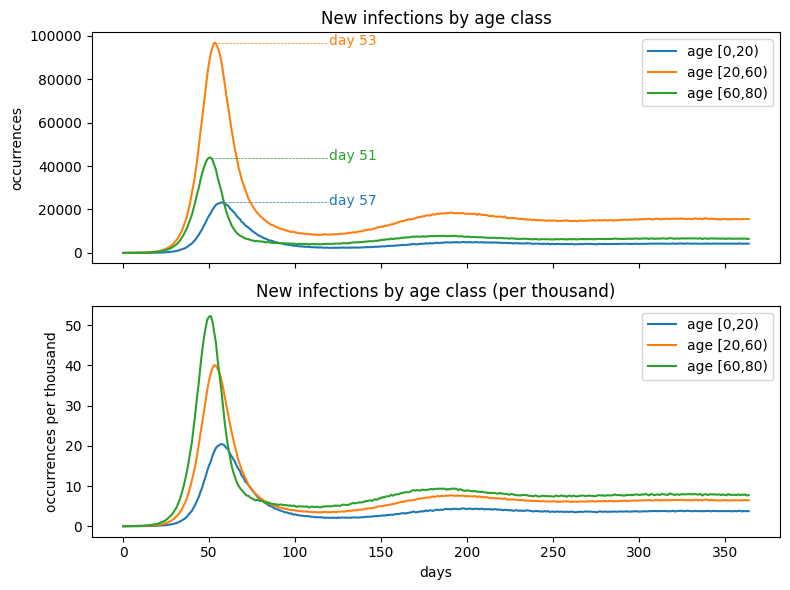

Running simulation (StandardSimulation):
• 2022-01-01 to 2023-01-01 (365 days)
• 1 geo nodes
|####################| 100% 
Runtime: 0.069s


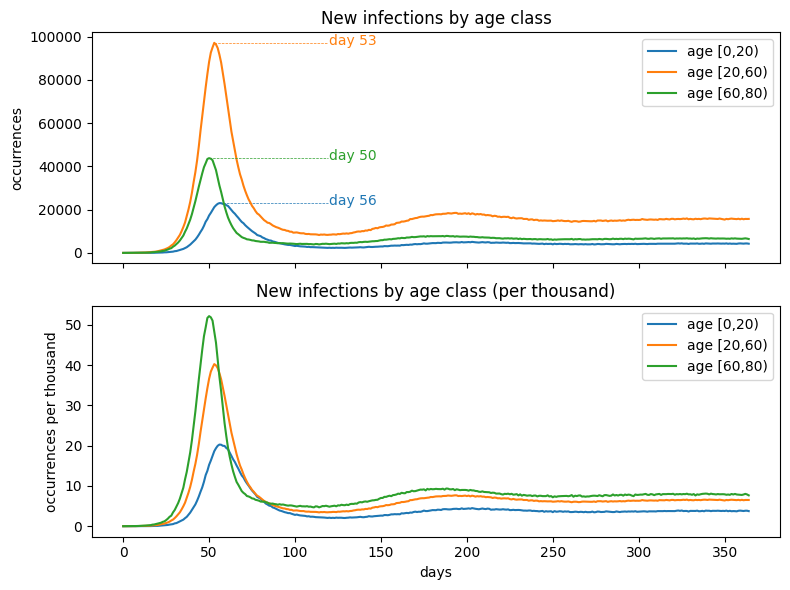

In [4]:
run_experiment(construct_ipm_1(), infection_events_ipm1)
run_experiment(construct_ipm_2(), infection_events_ipm2)
run_experiment(construct_ipm_3(), infection_events_ipm3)

## Aside: code generation

In [5]:
# This is some quick-and-dirty code generation I used in defining the above model (IPM 1), by copy-pasting the results.
# Generating this meant I was less likely to make typo bugs.
# So yeah, this cell is chronologically out of order, but I stuck this at the end so it doesn't distract from the real content above.

# Compartments
for c, a in [(c, a) for c in ['S', 'I', 'R'] for a in [1, 2, 3]]:
    print(f"compartment({c}_{a}),")

print()

# Beta parameter definitions
for a, b in [(a, b) for a in [1, 2, 3] for b in [1, 2, 3]]:
    print(f"param('beta_{a}{b}', shape=Shapes.TxN),")

print()

# Beta parameter unpacking
params = [f"beta_{a}{b}" for a in [1, 2, 3] for b in [1, 2, 3]]
print(", ".join(params))

print()

# Edges
for a in [1, 2, 3]:
    beta_times_I = [f"beta_{a}{b} * I_{b}" for b in [1, 2, 3]]
    print(
        f"edge(S_{a}, I_{a}, rate=S_{a} * ({' + '.join(beta_times_I)}) / N),")

for a in [1, 2, 3]:
    print(f"edge(I_{a}, R_{a}, rate=gamma * I_{a}),")

for a in [1, 2, 3]:
    print(f"edge(R_{a}, S_{a}, rate=xi * R_{a}),")

compartment(S_1),
compartment(S_2),
compartment(S_3),
compartment(I_1),
compartment(I_2),
compartment(I_3),
compartment(R_1),
compartment(R_2),
compartment(R_3),

param('beta_11', shape=Shapes.TxN),
param('beta_12', shape=Shapes.TxN),
param('beta_13', shape=Shapes.TxN),
param('beta_21', shape=Shapes.TxN),
param('beta_22', shape=Shapes.TxN),
param('beta_23', shape=Shapes.TxN),
param('beta_31', shape=Shapes.TxN),
param('beta_32', shape=Shapes.TxN),
param('beta_33', shape=Shapes.TxN),

beta_11, beta_12, beta_13, beta_21, beta_22, beta_23, beta_31, beta_32, beta_33

edge(S_1, I_1, rate=S_1 * (beta_11 * I_1 + beta_12 * I_2 + beta_13 * I_3) / N),
edge(S_2, I_2, rate=S_2 * (beta_21 * I_1 + beta_22 * I_2 + beta_23 * I_3) / N),
edge(S_3, I_3, rate=S_3 * (beta_31 * I_1 + beta_32 * I_2 + beta_33 * I_3) / N),
edge(I_1, R_1, rate=gamma * I_1),
edge(I_2, R_2, rate=gamma * I_2),
edge(I_3, R_3, rate=gamma * I_3),
edge(R_1, S_1, rate=xi * R_1),
edge(R_2, S_2, rate=xi * R_2),
edge(R_3, S_3, rate=xi * R_